## Importanto dependências

In [1]:
from matplotlib import font_manager

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import matplotlib as mpl

## Baixando datasets (Windows)

In [ ]:
!pip install -q kaggle

In [ ]:
!cp ~/Downloads/kaggle.json %HOME%/.kaggle/kaggle.json

In [ ]:
DATADIR="data"
![ ! -d "$DATADIR" ] && mkdir "$DATADIR"

!kaggle datasets download -d anokas/kuzushiji -p "$DATADIR" --unzip

## Instalando fontes e adicionando ao matplotlib (Windows)

In [ ]:
!echo %HOME%;

In [ ]:
system = platform.system()

if system == 'Windows':
    font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
    font_path = os.path.join(os.path.expanduser('~'), 'AppData\Local\Microsoft\Windows\Fonts\TakaoPGothic.ttf')
    font_manager.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'TakaoPGothic'
    
    # Check if the font is installed
    print(font_manager.findfont("TakaoPGothic"))
# !ls C:\\Users\\medin\\anaconda3\\envs\\vision\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf
elif system == 'Linux':
    pass

## Funções auxiliares

In [4]:
# Loading classmap
class_to_hiragana = pd.read_csv('data\k49_classmap.csv').to_dict(orient='index')

def get_hiragana(key):
  return class_to_hiragana[key]['char']

def flatten(x):
    n_samples, width, height, _ = x.shape
    
    return np.reshape(x, (n_samples, width*height))

def change_theme(color):
    mpl.rcParams['axes.labelcolor'] = color
    mpl.rcParams['xtick.color'] = color
    mpl.rcParams['ytick.color'] = color
    mpl.rcParams['text.color'] = color
    
def get_classes_by_frequency(y_train):
    classes, frequencies = np.unique(y_train, return_counts=True)
    sorted_lists = sorted(zip(frequencies, classes))
    frequencies, classes = [pair for pair in zip(*sorted_lists)]
    
    hiraganas = [get_hiragana(_class) for _class in classes]
    
    return frequencies, classes, hiraganas

---
## Pré-processamento dos dados

### Carregando dados e separando conjuntos de treino e teste

In [5]:
# Loading data from compressed files
x_train = np.load('data\\k49-train-imgs.npz')['arr_0'].astype('float32')
x_test = np.load('data\\k-49-test-imgs.npz')['arr_0'].astype('float32')

# Normalize data between 0 and 1
x_train /= 255
x_test /= 255

# Adding one extra "channel" dimension
x_train_expanded = np.expand_dims(x_train, axis=-1)
x_test_expanded = np.expand_dims(x_test, axis=-1)

# Loading labels from compressed files
y_train_original = np.load('data\k49-train-labels.npz')['arr_0']
y_test_original = np.load('data\k49-test-labels.npz')['arr_0']

n_classes = len(np.unique(y_train_original))

# One hot encoding for cross entropy loss (for later when training the model)
y_train = np_utils.to_categorical(y_train_original, n_classes)
y_test = np_utils.to_categorical(y_test_original, n_classes)

In [6]:
separator = f"\n{'---' * 35}\n"
print(f'Original training data shape: {x_train.shape} -  Expanded training data shape: {x_train_expanded.shape}')
print(f'Original testing data shape: {x_test.shape}   -  Expanded testing data shape: {x_test_expanded.shape}', end=separator)

print('Number of training samples: ', x_train.shape[0])
print('Number of testing samples: ', x_test.shape[0], end=separator)

print(f'Images resolution: {x_train.shape[1]}x{x_train.shape[2]}')
print('Number of classes: ', n_classes)

Original training data shape: (232365, 28, 28) -  Expanded training data shape: (232365, 28, 28, 1)
Original testing data shape: (38547, 28, 28)   -  Expanded testing data shape: (38547, 28, 28, 1)
---------------------------------------------------------------------------------------------------------
Number of training samples:  232365
Number of testing samples:  38547
---------------------------------------------------------------------------------------------------------
Images resolution: 28x28
Number of classes:  49


### Visualizando dados

In [7]:
def visualize_random_hiraganas(x, y, n_cols=10, n_rows=5, theme_path='dark'):
  n_imgs = n_cols * n_rows
  rand_idxs = np.random.randint(x.shape[0], size=n_imgs)

  rand_samples = x[rand_idxs]
  x = [get_hiragana(y[idx]) for idx in rand_idxs]

  fig = plt.figure(figsize=(n_cols, n_rows))
  plt.subplots_adjust(top=1)

  for i in range(n_imgs):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    ax.set_title(x[i])

    ax.tick_params(
      axis='both',
      which='both',
      labelleft=False,
      labelbottom=False,
      bottom=False,
      left=False
    )
    
    ax.imshow(rand_samples[i], cmap='gray')

  plt.tight_layout()
  plt.savefig(f'plots/{theme_path}/{n_imgs}_random_samples', transparent=True)
  plt.show()

def visualize_classes_imbalance(y, title=None, theme_path='dark'):
  classes, frequencies = np.unique(y, return_counts=True)
  sorted_lists = sorted(zip(frequencies, classes))
  frequencies, classes = [list(pair) for pair in zip(*sorted_lists)]

  hiraganas = [get_hiragana(class_) for class_ in classes]

  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(111)
  ax1.scatter(hiraganas, frequencies)

  title = title or 'classes_imbalance'
  plt.tight_layout()
  plt.savefig(f'plots/{theme_path}/{title}', transparent=True)
  plt.show()

def visualize_same_class_samples(x, y, n_classes=5, n_samples=5, theme_path='dark'):
  n_rows = n_classes
  n_columns = n_samples

  np.random.seed()

  classes_range = np.unique(y) # 0 a 48
  rand_classes = np.random.randint(classes_range[0], classes_range[-1], size=n_rows)

  fig = plt.figure(figsize=(n_columns, n_rows), dpi=100)
  plt.subplots_adjust(top=1)
  
  n_imgs = n_rows + n_columns  
  i = 1
  while i <= n_imgs:
    for class_ in rand_classes:
      rand_class_idxs = np.where(y == class_)[0][:n_columns]
      for sample_idx in rand_class_idxs:
        ax = fig.add_subplot(n_rows, n_columns, i)
        ax.set_title(get_hiragana(class_))

        ax.tick_params(
          axis='both',
          which='both',
          labelleft=False,
          labelbottom=False,
          bottom=False,
          left=False
        )
        
        ax.imshow(x[sample_idx], cmap='gray')
        i += 1
      
  plt.tight_layout()
  plt.savefig(f'plots/{theme_path}/{n_rows}_classes_train_samples', transparent=True)
  plt.show()

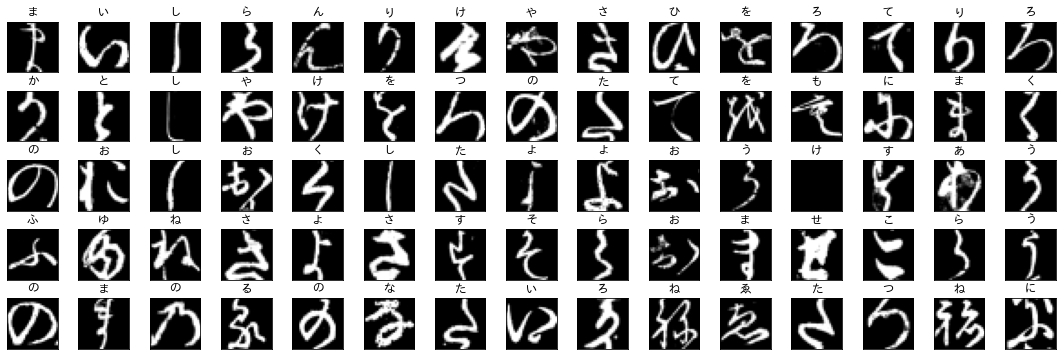

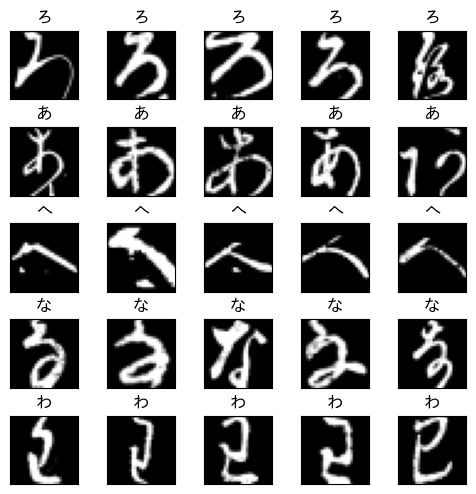

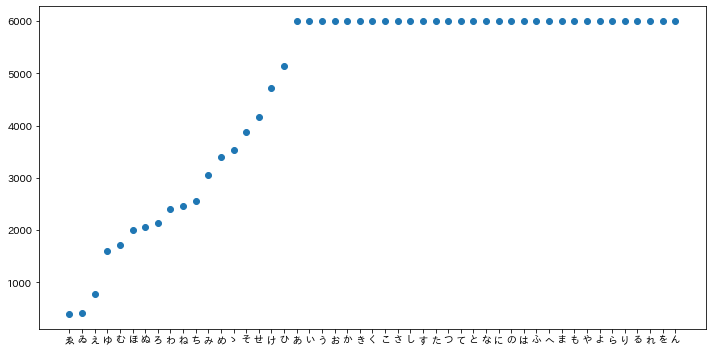

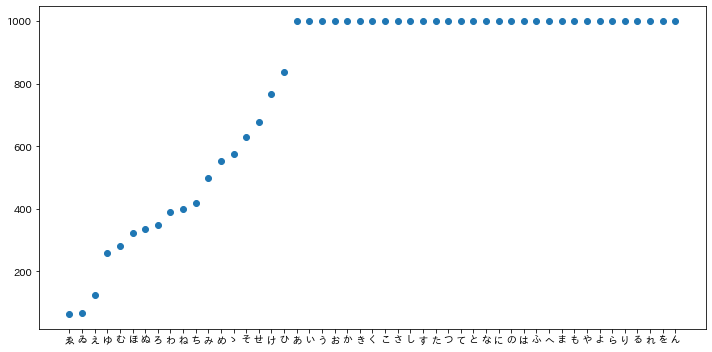

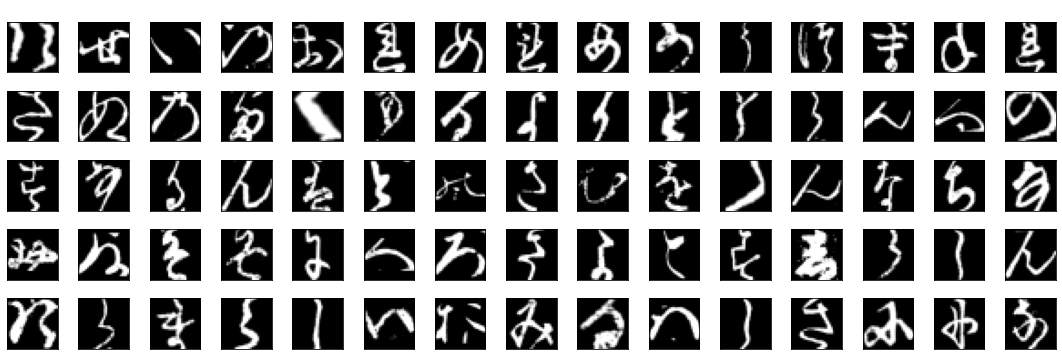

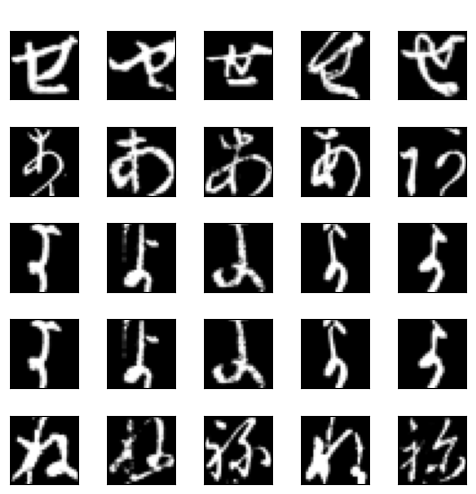

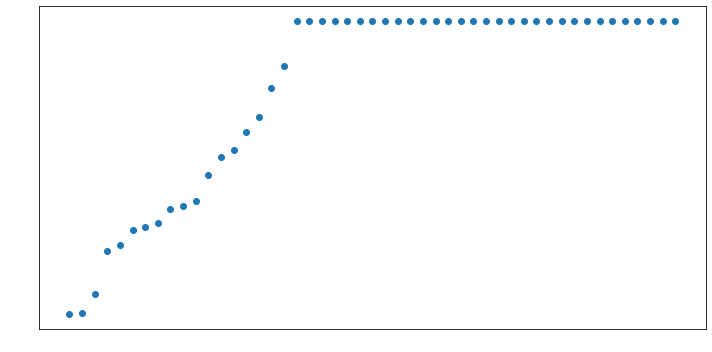

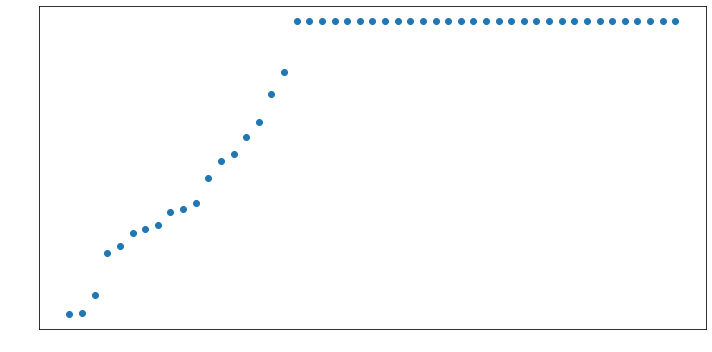

In [7]:
if not os.path.isdir('plots/dark'):
    os.makedirs('plots/dark')
if not os.path.isdir('plots/light'):
    os.makedirs('plots/light')

change_theme('black')
visualize_random_hiraganas(x_train, y_train_original, n_cols=15)
visualize_same_class_samples(x_train, y_train_original)
visualize_classes_imbalance(y_train_original, title='classes_imbalance_train_samples')
visualize_classes_imbalance(y_test_original, title='classes_imbalance_test_samples')

change_theme('white')
visualize_random_hiraganas(x_train, y_train_original, n_cols=15, theme_path='light')
visualize_same_class_samples(x_train, y_train_original, theme_path='light')
visualize_classes_imbalance(y_train_original, title='classes_imbalance_train_samples', theme_path='light')
visualize_classes_imbalance(y_test_original, title='classes_imbalance_test_samples', theme_path='light')

---
## Treinamento

### Criando modelos
A ideia é treinar vários modelos com diferentes parâmetros (número de camadas, filtros, tamanho dos filtros, otimizadores, etc) e comparar a performance, através da acurácia e da análise da curva ROC obtidas pelos modelos treinados.

Foi criada uma função **build_network_model** para gerar modelos, dados os parâmetros necessários, estes são:
- name               - nome usado nomear o arquivo h5 que irá guardar os pesos treinados de cada modelo
- network_layers     - lista de camadas sequenciais do modelo (camadas do módulo layers do keras)
- compilation_params - dict com parâmetros da compilação do modelo (otimizador, função de custo, etc)
- show_summary       - flag que faz a função imprimir uma sumarização do modelo construído

In [8]:
def build_network_model(name, network_layers, compilation_params, show_summary=False):
    model = keras.Sequential(
        network_layers,
        name
    )
    
    model.compile(**compilation_params)
    
    if show_summary:
        model.summary()
    
    return model

### Modelos
Dois tipos de modelos foram usados: redes neurais (NN) e redes neurais convolucionais (CNNs). São criadas um total de 6 redes neurais e 6 redes neurais convolucionais.<br>
As 6 redes neurais são:
- NN_1_sgd
- NN_2_sgd
- NN_1_adam
- NN_2_adam
- NN_dense
- NN_dense_batch_form

E as 6 redes neurais convolucionais são:
- CNN_1_sgd
- CNN_2_sgd
- CNN_1_adam
- CNN_2_adam
- CNN_dense
- CNN_dense_batch_form

O objetivo das 4 primeiras redes, de cada tipo de modelo, é comparar o impacto na performance que diferentes otimizadores e diferentes quantidades de camadas (para NNs) ou filtros (para CNNs) faz.<br>
As duas últimas redes de cada tipo de modelo são redes mais custosas computacionalmente, com muito mais camadas ou filtros; sendo que metade delas usa [Batch Normalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) e a outra metade não. O objetivo é comparar se uma quantidade muito grande de camadas ou filtros, de fato melhora a performance consideravelmente, e se além disso, adicionar camadas de batch normalization ajuda.


In [9]:
neural_networks = [
    build_network_model(
        'NN_1_sgd',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_2_sgd',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=128, activation='relu', name='dense_2'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_1_adam',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_2_adam',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=128, activation='relu', name='dense_2'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_dense',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=128, activation='relu', name='dense_1'),
            layers.Dense(units=256, activation='relu', name='dense_2'),
            layers.Dense(units=512, activation='relu', name='dense_3'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_dense_batch_norm',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=128, activation='relu', name='dense_1'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=256, activation='relu', name='dense_2'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=512, activation='relu', name='dense_3'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    )
]

conv_neural_networks = [
    build_network_model(
        'CNN_1_adam',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_2_adam',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=128, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_1_sgd',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_2_sgd',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=128, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_dense',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=512, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),    
    build_network_model(
        'CNN_dense_batch_norm',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.BatchNormalization(axis=1),
            layers.Conv2D(filters=512, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.BatchNormalization(axis=1),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    )
]

## Treinamento
O treinamento consiste em fazer o fit de cada modelo no conjunto de treino, separando 30% desse conjunto para validação e usando batches com 128 samples. Após o treinamento são salvos os pesos para que o treinamento não precise ser executado novamente no futuro, mas apenas carregado (vide seção [Carregando Modelos](#carregando-modelos) abaixo).

In [10]:
def train_model(model, training_params, output_path='weights'):
    model.fit(**training_params)
    
    if not os.path.isdir(output_path):
        os.mkdir(output_path)
        
    model.save_weights(os.path.join(output_path, f'{model.name}.h5'))
    
    return model

### ATENÇÃO: só executar célula abaixo se o treinamento não tiver sido feito (basta ver se o diretório weights contém todos arquivos .h5 correspondentes aos modelos criados).

In [ ]:
x_train_flattened = flatten(x_train_expanded)

nn_trained_models = [
    train_model(
        nn_model,
        {'x': x_train_flattened, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3}
    )
    for nn_model in neural_networks
]

cnn_trained_models = [
    train_model(
        cnn_model,
        {'x': x_train_expanded, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3}
    )
    for cnn_model in conv_neural_networks
]

---
### Carregando modelos
Se os modelos já foram treinados, basta carregar seus pesos a partir dos arquivos .h5 para avaliá-los.

In [11]:
def load_model(models, model_name):
    model = list(filter(lambda x: x.name == model_name, models))[0]
    model.load_weights(f'weights/{model_name}.h5')
    
    return model

weights_filenames = os.listdir('weights')

nn_trained_models = [load_model(neural_networks, filename[:-3]) for filename in weights_filenames if filename.startswith('NN')]
cnn_trained_models = [load_model(conv_neural_networks, filename[:-3]) for filename in weights_filenames if filename.startswith('CNN')]

## Avaliação dos Modelos

### Acurácia
A avaliação dos modelos irá começar usando métricas mais simples: acurácia e loss.

In [12]:
def evaluate_model(model, x_test, y_test, should_flatten=False) -> tuple[float, float]:
    if should_flatten:
        x_test = flatten(x_test)
        
    return model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [13]:
nn_losses = []
nn_accuracies = []
cnn_losses = []
cnn_accuracies = []

for model in nn_trained_models:    
    loss, acc = evaluate_model(model, x_test_expanded, y_test, should_flatten=True)
    nn_losses.append(loss)
    nn_accuracies.append(acc)
    
for model in cnn_trained_models:
    loss, acc = evaluate_model(model, x_test_expanded, y_test)
    cnn_losses.append(loss)
    cnn_accuracies.append(acc)

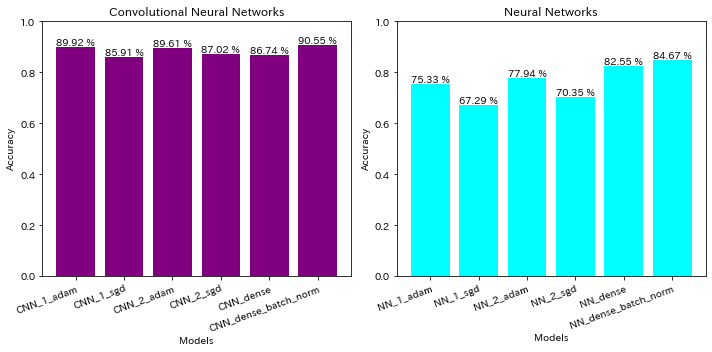

In [41]:
cnn_models_names = [trained_model.name for trained_model in cnn_trained_models]
nn_models_names = [trained_model.name for trained_model in nn_trained_models]

fig, axes = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

subplots = [
    {'ax': axes[0], 'xtick_labels': cnn_models_names, 'data': cnn_accuracies, 'color': 'purple', 'title': 'Convolutional Neural Networks'},
    {'ax': axes[1], 'xtick_labels': nn_models_names, 'data': nn_accuracies, 'color': 'cyan', 'title': 'Neural Networks'},
]

for subplot in subplots:
    ax, xtick_labels, data, color, title = subplot.values()

    hbars = ax.bar(xtick_labels, data, color=color)
    
    ax.set_title(title)
    ax.set_ylim([0, 1])
    ax.set_xticks(xtick_labels)
    ax.set_xticklabels(labels=xtick_labels, rotation=20, ha='right', rotation_mode='anchor')
    ax.set(xlabel='Models', ylabel='Accuracy')
    
    ax.bar_label(hbars, labels=[f'{100*d:.2f} %' for d in data])

plt.tight_layout()
plt.savefig('plots/accuracies.svg')
plt.show()

Podemos observar que:
- todas CNNs apresentam acurácia superior às NNs
- os modelos que usaram o SGD como otimizador obtiveram menor acurácia, comparados com os que usaram ADAM
- a CNN mais densa com Batch Normalization (e de longe a mais custosa computacionalmente) obteve acurácia muito semelhante a CNNs menos densas e sem Batch Normalization
- já a NN mais densa com Batch Normalization se saiu, levemente, melhor quando comparadas com as outras NNs

### AUC e Curva ROC
Como mencionado anteriormente, o dataset é (propositalmente) desbalanceado, com algumas classes possuindo muito menos exemplos que outras. Portanto apenas analisar a acurária obtida pelos modelos não é suficiente para sumarizar seus desempenhos, é preciso usar métricas que levam em consideração o desbalanceio do dataset.<br>
A metodologia mais comum é, a partir da [Matriz de Confusão](https://www.youtube.com/watch?v=Kdsp6soqA7o&t=12s), extrair métricas como: precisão, recall, sensibilidade, especificidade; usadas para plotar a curva [ROC](https://www.youtube.com/watch?v=4jRBRDbJemM) de cada modelo e suas respectivas áreas sob a curva (AUC).<br>

### Curva ROC Multiclasse
Por padrão, a curva ROC é utilizada para classificadores binários, sendo um **plot por modelo**. Nesses casos, a comparação entre os modelos não apresenta problemas.<br>
Entretanto, para classificadores multiclasse (ou categóricos), é necessário utilizar uma estratégia, tal como a "one-vs-all", onde, para **um modelo**, é plotada uma curva ROC por classe, i.e., considera-se uma classe como a positiva e todas as outras como negativas. Logo, há vários plots de curva ROC por modelo, tornando difícil compará-los.<br>
Para ficar mais claro, vamos ilustrar o problema usando o dataset utilizado neste trabalho. Como o dataset Kuzushiji-49 contém 49 classes, isso significa que há 49 curvas ROC a serem plotadas para cada modelo. Execute a célula abaixo para ver o resultado:

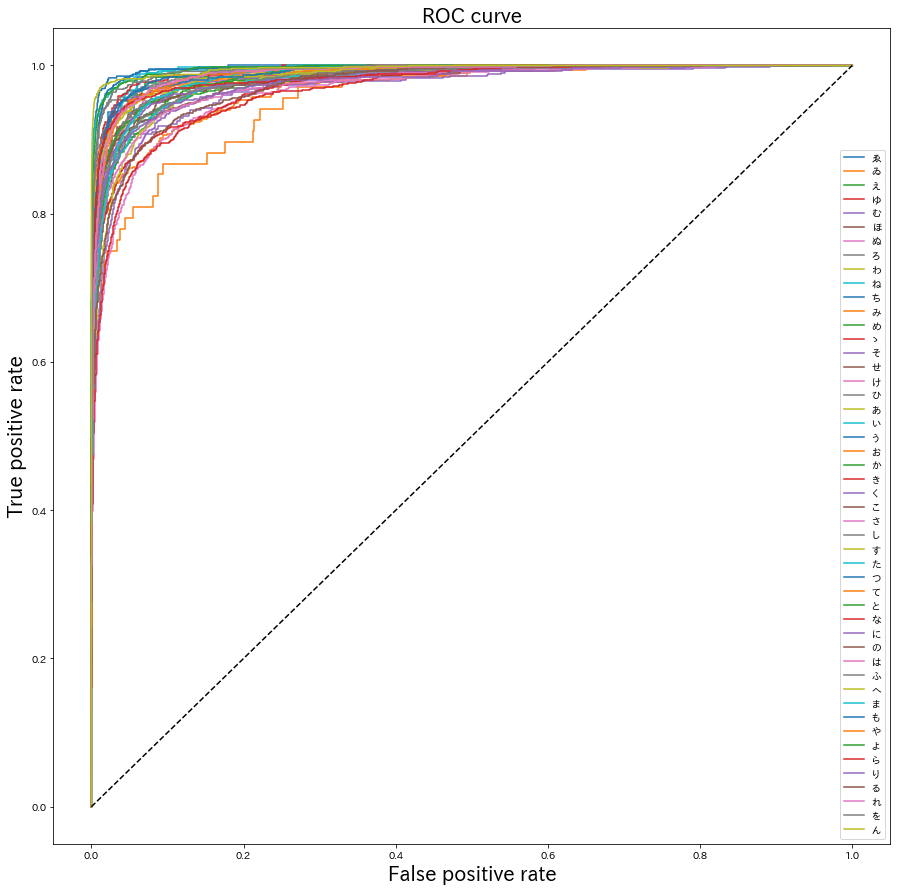

In [43]:
# def plot_roc_curve(trained_model, x_test, y_test):
trained_model = nn_trained_models[0]

x = flatten(x_test_expanded)
y = y_test
y_probs = trained_model.predict(x)

_, classes, hiraganas = get_classes_by_frequency(y_train_original)

roc_curves = [roc_curve(y[:, _class], y_probs[:, _class]) for _class in classes]

fig = plt.figure(figsize=(15, 15))

for i in range(len(roc_curves)):
    fpr, tpr, _ = roc_curves[i]
    _class = classes[i]
    plt.plot(fpr, tpr, label=get_hiragana(_class))

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best')
plt.savefig('plots/ROC_nightmare.svg')
plt.show()

É possível notar que o modelo em questão aprendeu algumas classes melhor que outras (quanto mais "alta e para a esquerda" ela for - próxima do "céu ROC") porém é difícil tirar quaisquer conclusões devido a quantidade de classes.
Para nossa felicidade, existe uma maneira de sumarizar esses resultados, a área sob a curva - AUC.

### AUC Multiclasse
Quando lidando com classificadores binários, uma maneira de comparar a curva ROC (note que está no singular) de cada modelo é através da AUC, pois como se trata apenas de um valor, basta verificar quem possui o maior para saber quem é o melhor.<br>
No caso de classificadores multiclasse temos, para um modelo, várias curvas ROC, e portanto um valor de AUC para cada classe (considerando a abordagem "one-vs-all").<br>
A seguir plotamos os valores de AUC para cada classe, fazendo a seguinte comparação entre os modelos:
- NN com otimizador ADAM com maior acurácia vs NN com otimizador SGD com maior acurácia
- CNN com otimizador ADAM com maior acurácia vs CNN com otimizador SGD com maior acurácia
- NN com maior acurácia vs CNN com maior acurácia
- NN densa com e sem Batch Normalization
- CNN densa com e sem Batch Normalization

### SPOILER: a visualização desses valores em gráficos de barra é interessante, para ter uma noção geral do "desbalanceio no aprendizado de cada classe", mas não muito útil para extrair conclusões definitivas, isso será feito na próxima seção.

In [17]:
def get_auc(_class, y_probs):
    """
        Given a list of predictions ``y_probs`` calculates the fpr (False Positive Rate) and tpr (True Positive Rate) 
        to get the AUC value for the given ``_class``
        
    """
    fpr, tpr, _ = roc_curve(y_test[:, _class], y_probs[:, _class])
    return auc(fpr, tpr)

In [18]:
def compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2):   
    fig, axes = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
    
    _, classes, hiraganas = get_classes_by_frequency(y_train_original)
    
    subplots = [
        {'ax': axes[0], 'model': model_1, 'y_probs': y_probs_1, 'title': model_1.name, 'color': 'purple'},
        {'ax': axes[1], 'model': model_2, 'y_probs': y_probs_2, 'title': model_2.name, 'color': 'cyan'}
    ]
    
    for subplot in subplots:
        ax, model, y_probs, title, color = subplot.values()
        multi_class_auc = [get_auc(_class, y_probs) for _class in classes]
        
        ax.bar(hiraganas, multi_class_auc, color=color)
        ax.set_ylim([0.9, 1])
        ax.set_title(subplot['title'])
        ax.set(xlabel='Classes', ylabel='AUC')

    plt.tight_layout()
    plt.savefig(f'plots/{model_1.name}_auc_x_{model_2.name}_auc.svg', format='svg')
    plt.show()

### Vamos calcular todas predições para podermos plotar as comparações usando a função acima.

### Atenção! A execução dessa célula demora.

In [16]:
nn_models_predictions = {model.name: model.predict(flatten(x_test_expanded)) for model in nn_trained_models}
cnn_models_predictions = {model.name: model.predict(x_test_expanded) for model in cnn_trained_models}

models_predictions = {**nn_models_predictions, **cnn_models_predictions}

---
### NN_2_adam vs NN_2_sgd

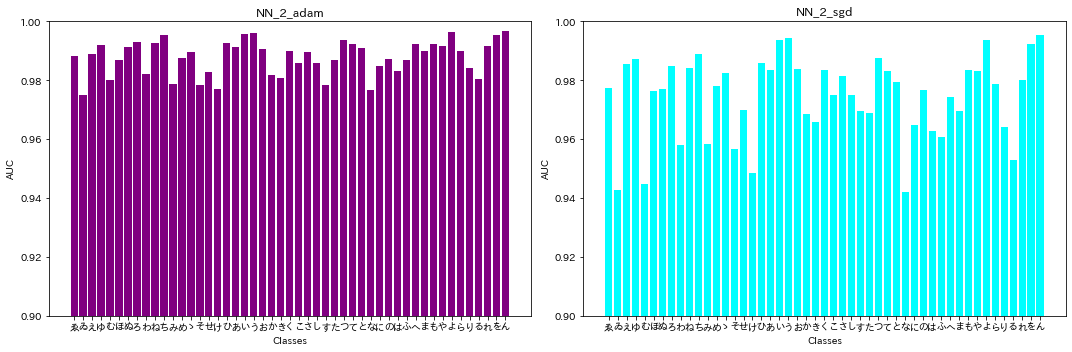

In [19]:
model_1 = nn_trained_models[2]
y_probs_1 = models_predictions[model_1.name]

model_2 = nn_trained_models[3]
y_probs_2 = models_predictions[model_2.name]

compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2)

---
### CNN_1_adam vs CNN_2_sgd

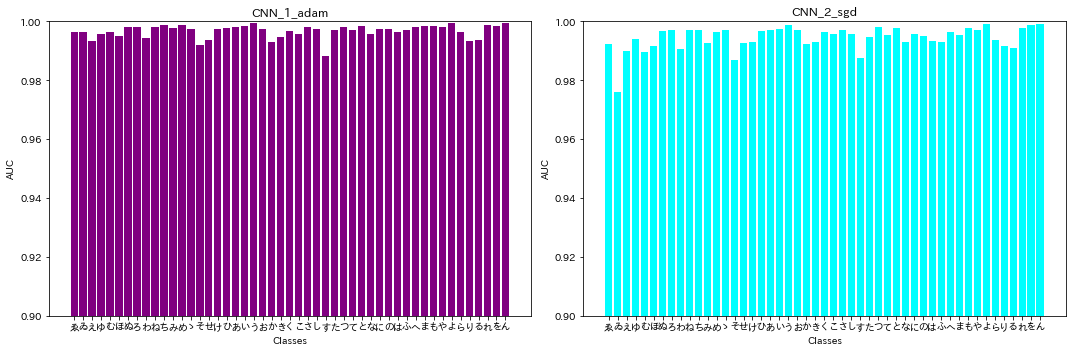

In [20]:
model_1 = cnn_trained_models[0]
y_probs_1 = models_predictions[model_1.name]

model_2 = cnn_trained_models[3]
y_probs_2 = models_predictions[model_2.name]

compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2)

---
### NN_dense_batch_norm vs CNN_dense_batch_norm

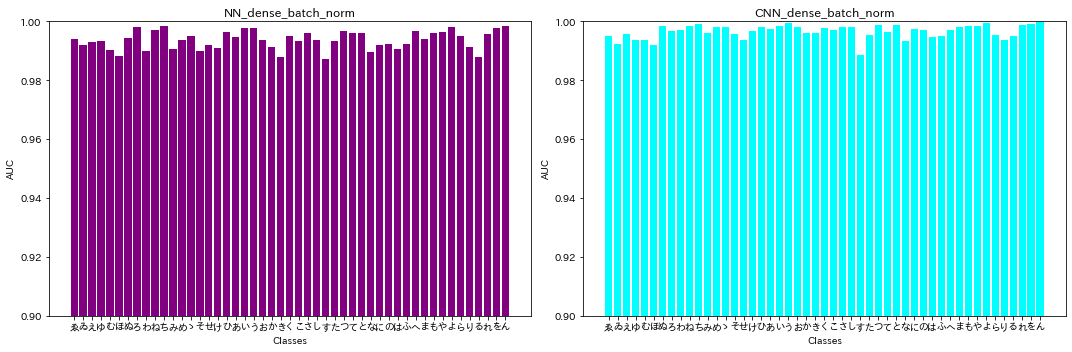

In [21]:
model_1 = nn_trained_models[5]
y_probs_1 = models_predictions[model_1.name]

model_2 = cnn_trained_models[5]
y_probs_2 = models_predictions[model_2.name]

compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2)

---
### NN_dense vs NN_dense_batch_norm

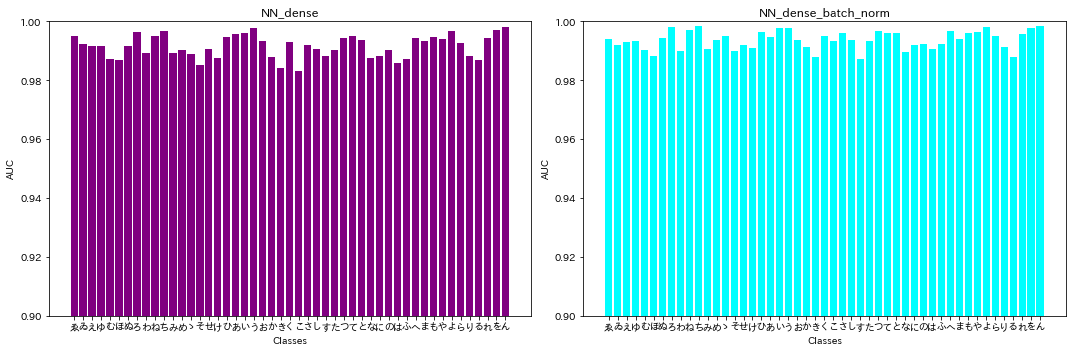

In [23]:
model_1 = nn_trained_models[4]
y_probs_1 = models_predictions[model_1.name]

model_2 = nn_trained_models[5]
y_probs_2 = models_predictions[model_2.name]

compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2)

---
### CNN_dense vs CNN_dense_batch_norm

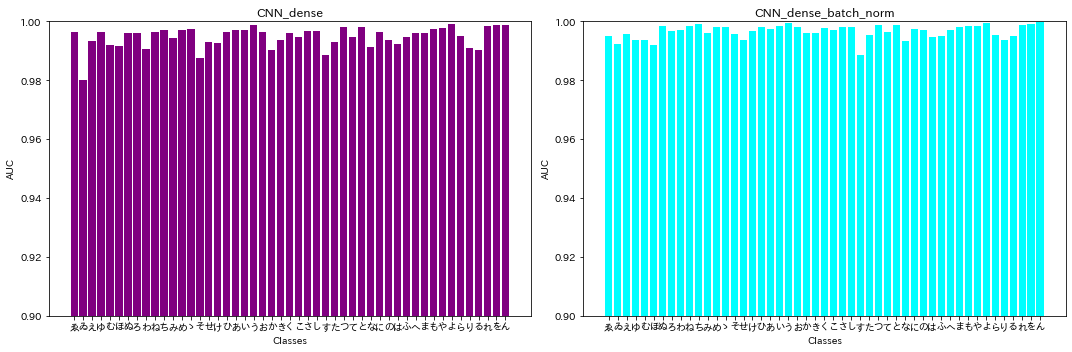

In [25]:
model_1 = cnn_trained_models[4]
y_probs_1 = models_predictions[model_1.name]

model_2 = cnn_trained_models[5]
y_probs_2 = models_predictions[model_2.name]

compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2)

### Conclusão Final da Análise AUC Multiclasse
Para sumarizar todos esses valores atrelados a cada modelo, foi usada uma média ponderada, onde as classes com menos exemplos possuem maior peso, para que, quanto maior o AUC para uma classe com menos amostras, mais ele contribui para a pontuação final do modelo.<br>

##### PS. 1: a ideia de como os pesos são atribuídos na média ponderada, é que devemos recompensar um modelo que aprende classes com menos exemplos tão bem quanto aprende classes com mais exemplos.

##### PS. 2: os pesos são definidos como o inverso da quantidade de amostras de cada classe.

In [50]:
def get_auc_avg_by_model(models, weights):
    def get_auc_avg(model):
        y_probs = models_predictions[model.name]
        aucs = [get_auc(_class, y_probs) for _class in classes]
        return np.average(aucs, weights=weights)
        
    return [get_auc_avg(model) for model in models]

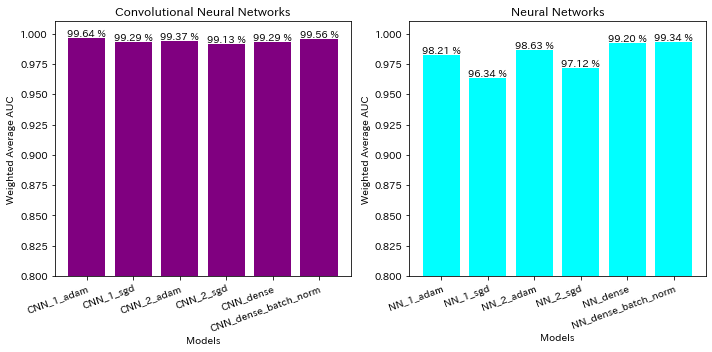

In [51]:
frequencies, classes, hiraganas = get_classes_by_frequency(y_train_original)
weights = [(1/fq) for fq in frequencies]

cnn_auc_avgs = get_auc_avg_by_model(cnn_trained_models, weights)
nn_auc_avgs = get_auc_avg_by_model(nn_trained_models, weights)

cnn_models_names = [trained_model.name for trained_model in cnn_trained_models]
nn_models_names = [trained_model.name for trained_model in nn_trained_models]

fig, axes = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

subplots = [
    {'ax': axes[0], 'xtick_labels': cnn_models_names, 'data': cnn_auc_avgs, 'color': 'purple', 'title': 'Convolutional Neural Networks'},
    {'ax': axes[1], 'xtick_labels': nn_models_names, 'data': nn_auc_avgs, 'color': 'cyan', 'title': 'Neural Networks'},
]

for subplot in subplots:
    ax, xtick_labels, data, color, title = subplot.values()

    hbars = ax.bar(xtick_labels, data, color=color)
    
    ax.set_title(title)
    ax.set_ylim([0.8, 1.01])
    ax.set_xticks(xtick_labels)
    ax.set_xticklabels(labels=xtick_labels, rotation=20, ha='right', rotation_mode='anchor')
    ax.set(xlabel='Models', ylabel='Weighted Average AUC')
    
    ax.bar_label(hbars, labels=[f'{100*d:.2f} %' for d in data])

plt.tight_layout()
plt.savefig('plots/auc_weighted_avg.svg')
plt.show()

## TODO Tirar conclusões finais das análises de acurácia e AUC 

ESCREVER AQUI AS CONCLUSÕES FINAIS

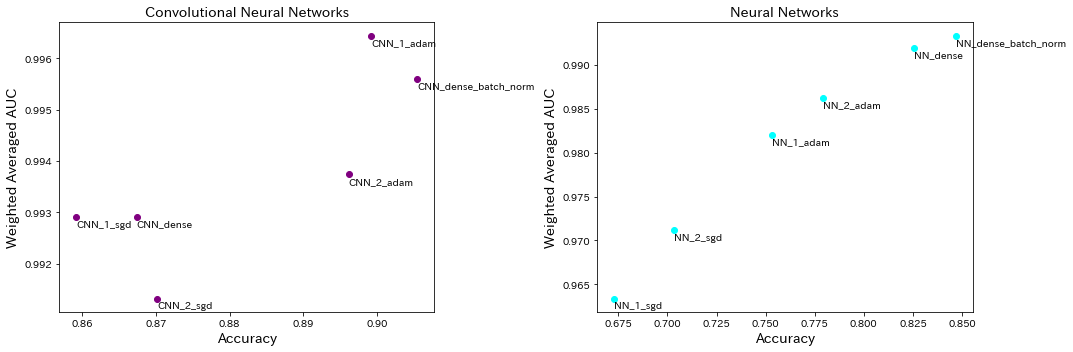

In [84]:
fig, axes = plt.subplots(figsize=(15,5), ncols=2, nrows=1)

subplots = [
    {'ax': axes[0], 'xtick_labels': cnn_models_names, 'x': cnn_accuracies, 'y': cnn_auc_avgs, 'color': 'purple', 'title': 'Convolutional Neural Networks'},
    {'ax': axes[1], 'xtick_labels': nn_models_names, 'x': nn_accuracies, 'y': nn_auc_avgs, 'color': 'cyan', 'title': 'Neural Networks'},
]

for subplot in subplots:
    ax, xtick_labels, x, y, color, title = subplot.values()

    ax.scatter(x, y, color=color)
    
    ax.set_title(title, fontsize=14)
    
    # TODO Arrumar intervalo dos ticks para comparação visual ser mais justa e realista
    
    ax.set_xlabel('Accuracy', fontsize=14)
    ax.set_ylabel('Weighted Averaged AUC', fontsize=14)
    for i, txt in enumerate(xtick_labels):
        ax.annotate(txt, (x[i], y[i]), xytext=(0,-10), textcoords='offset points')

plt.tight_layout()
plt.savefig('plots/scatter_accuracy_auc.svg')
plt.show()

## TODO Plots interessantes do que os modelos erram e acertam (super simples para de complicar esse trem)

MOSTRAR O QUE OS MELHORES MODELOS (DEFINIDOS NA SEÇÃO ACIMA) ACERTAM E ERRAM

### Referências
- https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
- https://uberpython.wordpress.com/2012/01/01/precision-recall-sensitivity-and-specificity/#:~:text=Specificity%20%E2%80%93%20how%20good%20a%20test,result%20it%27s%20most%20confident%20in.

In [98]:
import json

important_data = {
    'models_predictions': models_predictions,
    'cnn_accuracies': list(cnn_accuracies),
    'cnn_auc_avgs': list(cnn_auc_avgs),
    'cnn_losses': list(cnn_losses),
    'nn_accuracies': list(nn_accuracies),
    'nn_auc_avgs': list(nn_auc_avgs),
    'nn_losses': list(nn_losses)
}

print(models_predictions, end='\n\n\n\n')

with open('important_data.json', 'w') as f:
    json.dump(models_predictions, f)

{'NN_1_adam': array([[1.6723112e-08, 1.2820947e-09, 3.8672157e-10, ..., 2.3952606e-03,
        4.6108974e-07, 3.7915257e-07],
       [1.8948421e-04, 2.3760378e-05, 6.3721539e-15, ..., 1.2081032e-12,
        1.2550714e-09, 3.1979042e-08],
       [1.5420528e-09, 2.6306141e-10, 7.9429610e-09, ..., 3.9509578e-09,
        9.5243908e-13, 4.7728635e-04],
       ...,
       [7.8680972e-07, 7.5238115e-01, 1.3123342e-16, ..., 9.2415699e-16,
        1.1240336e-11, 6.8203767e-09],
       [7.7858662e-05, 4.7163078e-09, 8.7414487e-10, ..., 1.2616627e-09,
        2.2919149e-07, 6.8658548e-05],
       [7.0945780e-12, 2.4035529e-13, 6.1694648e-15, ..., 4.8063224e-12,
        9.9999392e-01, 2.2163442e-09]], dtype=float32), 'NN_1_sgd': array([[1.85609970e-05, 1.03301700e-05, 1.42793302e-04, ...,
        1.08888438e-04, 2.46165673e-05, 7.67471738e-06],
       [1.09162172e-02, 1.27703918e-03, 1.55435231e-11, ...,
        6.15150686e-09, 1.25920038e-10, 8.63482740e-07],
       [1.16353185e-08, 2.85114241e-1

TypeError: Object of type ndarray is not JSON serializable